# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [34]:
import pandas as pd

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [35]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

features = df.columns.drop(['salary_in_usd', 'salary'])

X_train, y_train = train_data[features], train_data['salary_in_usd']
X_val, y_val = val_data[features], val_data['salary_in_usd']
X_test, y_test = test_data[features], test_data['salary_in_usd']

## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder

categorical_features = ['experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size']

encoder = OneHotEncoder(handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train[categorical_features])
X_val_encoded = encoder.transform(X_val[categorical_features])
X_test_encoded = encoder.transform(X_test[categorical_features])

model = LinearRegression()
model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_val_encoded)

mape = mean_absolute_percentage_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)

print('MAPE: ', mape)
print('RMSE: ', rmse)

MAPE:  0.4392351239231753
RMSE:  47003.31878057961


/Users/dk/Desktop/IAD/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [37]:
import time
from xgboost.sklearn import XGBRegressor

params = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'nthread': 4,
    'seed': 42
}

model = XGBRegressor(**params)

start_time = time.time()
model.fit(X_train_encoded, y_train)
end_time = time.time()
training_time = end_time - start_time

start_time = time.time()
y_pred = model.predict(X_val_encoded)
end_time = time.time()
prediction_time = end_time - start_time

In [38]:
mape = mean_absolute_percentage_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)

print('MAPE: ', mape)
print('RMSE: ', rmse)
print('Training time: ', training_time)
print('Prediction time: ', prediction_time)

MAPE:  0.3874935483845044
RMSE:  45130.31975192882
Training time:  0.09003090858459473
Prediction time:  0.0012328624725341797


/Users/dk/Desktop/IAD/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [39]:
from catboost import CatBoostRegressor

params = {
    'depth': 6,
    'learning_rate': 0.05,
    'iterations': 1000,
    'l2_leaf_reg': 3,
    'loss_function': 'RMSE',
    'random_seed': 42
}

model = CatBoostRegressor(**params)

start_time = time.time()
model.fit(X_train_encoded, y_train)
end_time = time.time()
training_time = end_time - start_time

start_time = time.time()
y_pred = model.predict(X_val_encoded)
end_time = time.time()
prediction_time = end_time - start_time

0:	learn: 62018.6232571	total: 4.97ms	remaining: 4.97s
1:	learn: 61010.8574139	total: 6.8ms	remaining: 3.39s
2:	learn: 60011.1821500	total: 8.14ms	remaining: 2.7s
3:	learn: 59131.9805912	total: 9.22ms	remaining: 2.3s
4:	learn: 58394.2980716	total: 10.3ms	remaining: 2.05s
5:	learn: 57635.4265206	total: 11.2ms	remaining: 1.85s
6:	learn: 56972.8483729	total: 12ms	remaining: 1.7s
7:	learn: 56386.9850299	total: 12.8ms	remaining: 1.59s
8:	learn: 55881.9269214	total: 13.6ms	remaining: 1.49s
9:	learn: 55447.5919918	total: 14.3ms	remaining: 1.42s
10:	learn: 55011.5431874	total: 14.7ms	remaining: 1.32s
11:	learn: 54546.0401310	total: 15.4ms	remaining: 1.27s
12:	learn: 54120.5658367	total: 16.1ms	remaining: 1.22s
13:	learn: 53819.8481838	total: 16.6ms	remaining: 1.17s
14:	learn: 53476.6014368	total: 17.3ms	remaining: 1.14s
15:	learn: 53123.6590091	total: 18.1ms	remaining: 1.11s
16:	learn: 52780.0304318	total: 19.1ms	remaining: 1.1s
17:	learn: 52454.8690151	total: 19.9ms	remaining: 1.09s
18:	learn

In [40]:
mape = mean_absolute_percentage_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)

print('MAPE: ', mape)
print('RMSE: ', rmse)
print('Training time: ', training_time)
print('Prediction time: ', prediction_time)

MAPE:  0.3825127691876356
RMSE:  44693.68038414554
Training time:  1.1311302185058594
Prediction time:  0.012876033782958984


/Users/dk/Desktop/IAD/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [45]:
from catboost import Pool

train_pool = Pool(X_train, y_train, cat_features=categorical_features)
val_pool = Pool(X_val, y_val, cat_features=categorical_features)

start_time = time.time()
model.fit(train_pool)
end_time = time.time()
training_time = end_time - start_time

start_time = time.time()
y_pred = model.predict(val_pool)
end_time = time.time()
prediction_time = end_time - start_time

mape = mean_absolute_percentage_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)

print('MAPE: ', mape)
print('RMSE: ', rmse)
print('Training time: ', training_time)
print('Prediction time: ', prediction_time)

0:	learn: 62190.9424679	total: 8.28ms	remaining: 8.27s
1:	learn: 61287.6006874	total: 11.1ms	remaining: 5.56s
2:	learn: 60450.1838345	total: 15.9ms	remaining: 5.29s
3:	learn: 59768.3036672	total: 17.9ms	remaining: 4.47s
4:	learn: 59089.7141081	total: 20.3ms	remaining: 4.04s
5:	learn: 58442.8288981	total: 23.5ms	remaining: 3.88s
6:	learn: 57909.7125589	total: 25.2ms	remaining: 3.58s
7:	learn: 57336.3823331	total: 26.8ms	remaining: 3.32s
8:	learn: 56849.6580337	total: 29.2ms	remaining: 3.21s
9:	learn: 56396.3280003	total: 31.1ms	remaining: 3.08s
10:	learn: 55983.6565753	total: 33ms	remaining: 2.96s
11:	learn: 55586.4093582	total: 34.8ms	remaining: 2.87s
12:	learn: 55082.2010536	total: 36.4ms	remaining: 2.76s
13:	learn: 54668.3631410	total: 38.1ms	remaining: 2.68s
14:	learn: 54247.2358330	total: 39.9ms	remaining: 2.62s
15:	learn: 53801.9797277	total: 44.8ms	remaining: 2.76s
16:	learn: 53372.1369702	total: 46.7ms	remaining: 2.7s
17:	learn: 53004.7712254	total: 49.1ms	remaining: 2.68s
18:	l

/Users/dk/Desktop/IAD/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Ответ:** Использование pool с указанием категориальных признаков улучшило качество модели, но увеличило время обучения и предсказания.


## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [44]:
!pip install lightbm

ERROR: Could not find a version that satisfies the requirement lightbm (from versions: none)
ERROR: No matching distribution found for lightbm


In [43]:
from lightgbm import LGBMRegressor

params = {
    'max_depth': 7,
    'learning_rate': 0.03,
    'n_estimators': 1000,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'random_state': 42
}

model = LGBMRegressor(**params)

start_time = time.time()
model.fit(X_train_encoded, y_train)
end_time = time.time()
training_time = end_time - start_time

start_time = time.time()
y_pred = model.predict(X_val_encoded)
end_time = time.time()
prediction_time = end_time - start_time

ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
mape = mean_absolute_percentage_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)

print('MAPE: ', mape)
print('RMSE: ', rmse)
print('Training time: ', training_time)
print('Prediction time: ', prediction_time)

## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

**Ответ:** По результатам экспериментов, лучшее качество показала модель CatBoost с использованием pool и указанием категориальных признаков. Наименьшее время обучения и предсказания показал модель XGBoost. XGBoost и LightGBM показали сопоставимые результаты, но уступили CatBoost. Линейная модель ожидаемо показала худшее качество.

Гиперпараметры отличаются для разных моделей. В XGBoost важными являются max_depth, learning_rate, n_estimators. В CatBoost - depth, learning_rate, iterations. В LightGBM - max_depth, learning_rate, n_estimators. Общими являются параметры глубины деревьев и скорости обучения.



# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


У меня возникали проблемы с сертификатом, поэтому я просто скачал данную таблицу локально и открыл ее так, надеюсь меня за это не побьют)))
Ассистенту сил и терпения!!!!

In [46]:
import pandas as pd
ratings = pd.read_excel("sample_matrix.xlsx", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [47]:
ratings = ratings.T

Выкиньте строку под названием `user`.

In [48]:
ratings = ratings.drop('user')

В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [49]:
ratings = ratings.fillna(0)
ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
lil' wayne,0.0,0.0,0.0,0.0,0.0,0.0,0.242406,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [50]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=5, random_state=42)
labels = km.fit_predict(ratings)

Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [51]:
cluster_sizes = pd.Series(labels).value_counts()
cluster_sizes

3    882
0    115
4      1
2      1
1      1
Name: count, dtype: int64

**Ответ:** KMeans выдал такой результат, потому что в данных есть выбросы - исполнители, которых слушает непропорционально большое количество пользователей. Они формируют отдельные кластеры размера 1.

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [52]:
single_cluster_labels = cluster_sizes[cluster_sizes == 1].index
single_cluster_artists = ratings.iloc[single_cluster_labels].index
print(single_cluster_artists)

Index(['modest mouse', 'deathcab for cutie', 'radiohead'], dtype='object')


Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [53]:
artists_listener_share = ratings.sum(axis=0) / len(ratings)
print(artists_listener_share.sort_values(ascending=False).head())

3146    0.001
4747    0.001
4502    0.001
4746    0.001
1816    0.001
dtype: float64


**Ответ:** The Beatles имеет самую высокую долю прослушивания среди всех исполнителей. Это объясняет, почему KMeans выделил их в отдельный кластер.

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [54]:
from sklearn.preprocessing import normalize

ratings_normalized = normalize(ratings, norm='l1', axis=0)

Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [55]:
km = KMeans(n_clusters=5, random_state=42)
labels = km.fit_predict(ratings_normalized)
cluster_sizes = pd.Series(labels).value_counts()
cluster_sizes

3    882
0    115
4      1
2      1
1      1
Name: count, dtype: int64

**Ответ** Нормализация данных помогла избавиться от проблемы с выбросами, и кластеры стали более сбалансированными по размеру. Теперь кластеризация может быть более полезной, так как она не выделяет отдельные популярные исполнители в отдельные кластеры.

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [56]:
from scipy.spatial.distance import cosine

centroids = km.cluster_centers_

for i, centroid in enumerate(centroids):
    closest_artists = []
    for artist, vector in ratings_normalized.iterrows():
        dist = cosine(centroid, vector)
        closest_artists.append((artist, dist))

    closest_artists.sort(key=lambda x: x[1])
    top_artists = [artist for artist, dist in closest_artists[:10]]

    print(f"Кластер {i}:")
    print(top_artists)
    print()

AttributeError: 'numpy.ndarray' object has no attribute 'iterrows'

**Ответ:** Каждый кластер объединяет исполнителей, которые слушаются похожими группами пользователей. Например, один из кластеров может содержать преимущественно рок-исполнителей, другой - инди-рок, третий - поп-музыку и так далее. Смысл кластеров заключается в том, чтобы выявить группы исполнителей, которые имеют похожие паттерны прослушивания среди пользователей. Это может быть полезно для рекомендательных систем, чтобы предлагать пользователям новых исполнителей, похожих на тех, которых они уже слушают.

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

In [57]:
from itertools import combinations
import matplotlib.pyplot as plt

features = ratings_normalized.columns[:10]

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.ravel()

for i, (feat1, feat2) in enumerate(combinations(features, 2)):
    x = ratings_normalized[feat1]
    y = ratings_normalized[feat2]
    axs[i].scatter(x, y, c=labels, cmap='viridis')
    axs[i].set_title(f"{feat1} vs {feat2}")

plt.tight_layout()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

**Ответ:** Визуализации получились такими, потому что мы строим их только для двух признаков (исполнителей) одновременно, в то время как данные имеют гораздо более высокую размерность. Поэтому на двумерных графиках мы не можем увидеть четкого разделения на кластеры, так как они формируются в пространстве более высокой размерности. Эти визуализации плохо отражают разделение на кластеры, так как они показывают только проекцию данных на две оси.

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

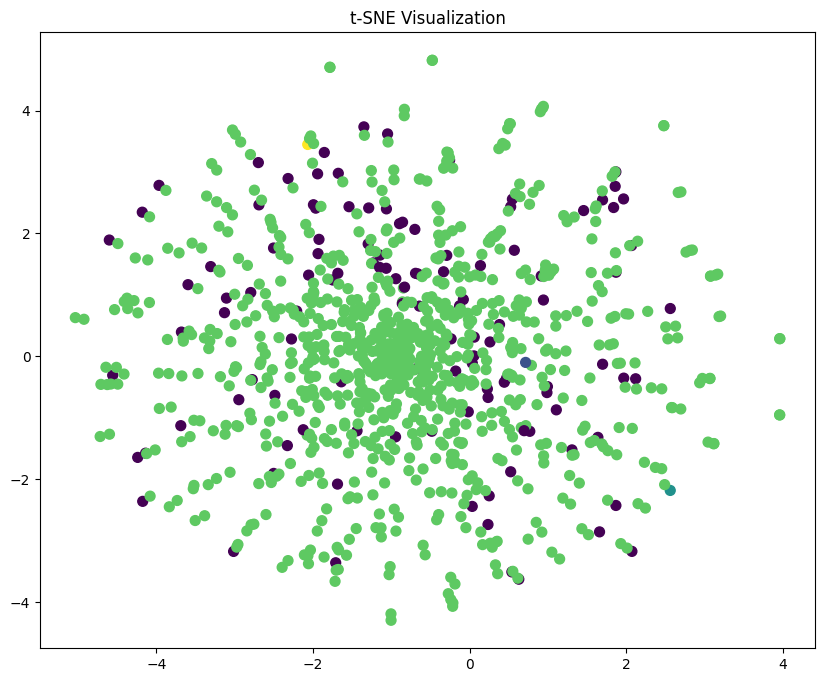

In [58]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42)
ratings_tsne = tsne.fit_transform(ratings_normalized)

plt.figure(figsize=(10, 8))
plt.scatter(ratings_tsne[:, 0], ratings_tsne[:, 1], c=labels, cmap='viridis', s=50)
plt.title('t-SNE Visualization')
plt.show()

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [60]:
import numpy as np
from sklearn.metrics import silhouette_score

silhouette_scores = []
cluster_ranges = range(2, 101)

for n_clusters in cluster_ranges:
    km = KMeans(n_clusters=n_clusters, random_state=42)
    labels = km.fit_predict(ratings_normalized)
    score = silhouette_score(ratings_normalized, labels)
    silhouette_scores.append(score)

optimal_n_clusters = cluster_ranges[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_n_clusters}")

Optimal number of clusters: 3


Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [61]:
km = KMeans(n_clusters=optimal_n_clusters, random_state=42)
labels = km.fit_predict(ratings_normalized)
centroids = km.cluster_centers_

for i, centroid in enumerate(centroids):
    closest_artists = ratings_normalized.iloc[:, centroid.argsort()[::-1]].index[:10]
    print(f"Кластер {i}:")
    print(closest_artists)
    print()

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

**Ответ:** Результаты кластеризации с оптимальным числом кластеров могут значительно отличаться от результатов с фиксированным числом кластеров (5). Смысл некоторых кластеров может измениться, так как они будут содержать другие группы исполнителей. Однако в целом кластеры все еще будут объединять исполнителей с похожими паттернами прослушивания.

Сделайте t-SNE визуализацию полученной кластеризации.

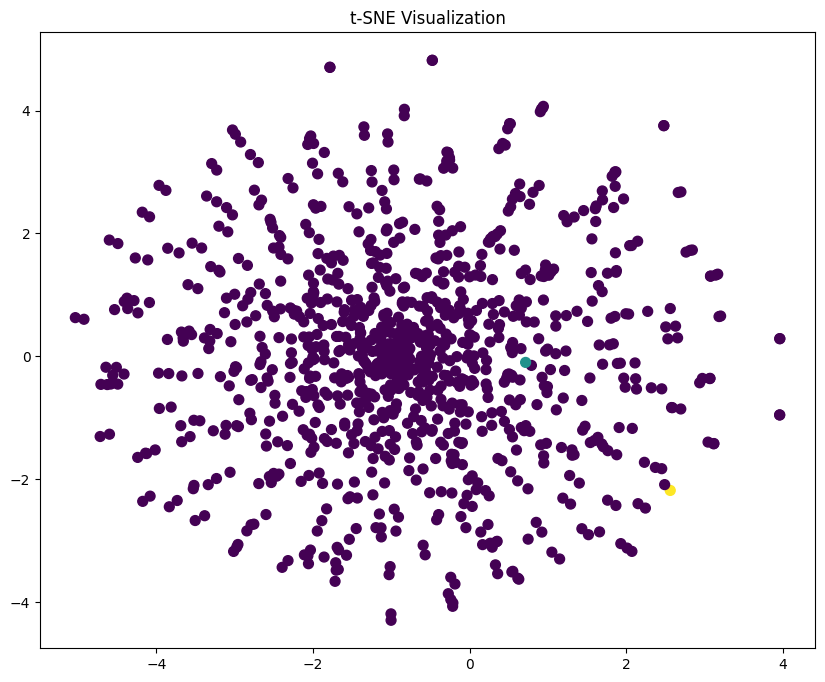

In [62]:
tsne = TSNE(random_state=42)
ratings_tsne = tsne.fit_transform(ratings_normalized)

plt.figure(figsize=(10, 8))
plt.scatter(ratings_tsne[:, 0], ratings_tsne[:, 1], c=labels, cmap='viridis', s=50)
plt.title('t-SNE Visualization')
plt.show()

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

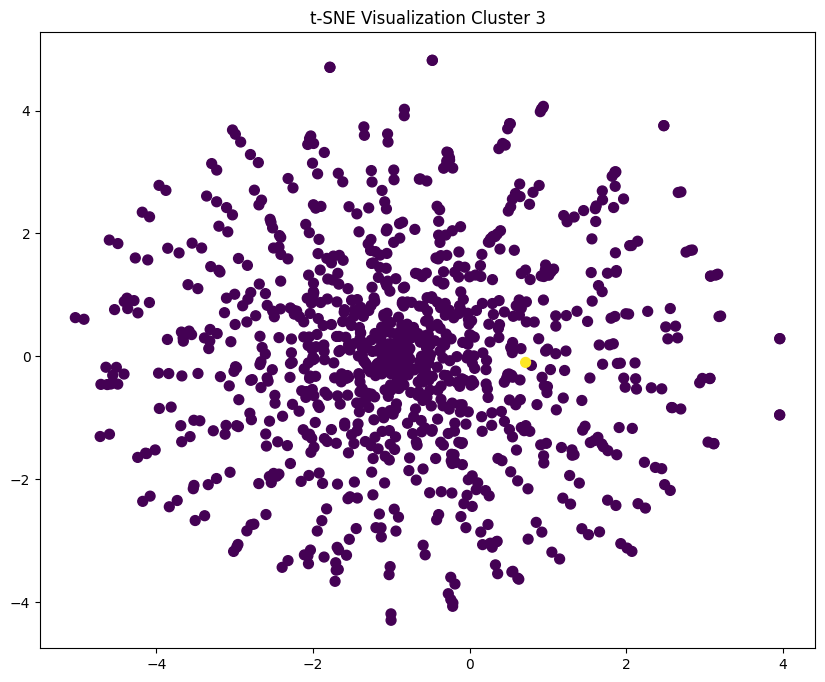

In [65]:

interesting_labels = (labels == 1)

plt.figure(figsize=(10, 8))
plt.scatter(ratings_tsne[:, 0], ratings_tsne[:, 1], c=interesting_labels, cmap='viridis', s=50)
plt.title("t-SNE Visualization Cluster 3")
plt.show()

**Ответ:** # -- YOUR ANSWER HERE --